In [1]:
model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"
# NUM_VIRTUAL_TOKENS = 4
NUM_EPOCHS = 1

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundational_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)

/home/xzrderek/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

In [5]:
from datasets import load_dataset

dataset_sentences = load_dataset('csv', data_files='data/spongebob_lines.csv')

data_sentences = dataset_sentences.map(lambda samples: tokenizer(samples["Lines"]), batched=True)
data_sentences = data_sentences['train'].train_test_split(test_size=0.2)

train_sample_sentences = data_sentences["train"].select(range(25))
test_sample_sentences = data_sentences["test"].select(range(25))
# train_sample_sentences = train_sample_sentences.remove_columns(['author', 'tags'])
display(train_sample_sentences)

Dataset({
    features: ['Lines', 'input_ids', 'attention_mask'],
    num_rows: 25
})

# Change Hyperparameters Here

In [6]:
from peft import  get_peft_model, PromptTuningConfig, TaskType, PromptTuningInit

tuning_init = [PromptTuningInit.RANDOM, PromptTuningInit.TEXT]
virtual_tokens = [2,4,8,16,32]


chosen_prompt_tuning_init, chosen_num_virtual_tokens = tuning_init[1], virtual_tokens[4]

generation_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=chosen_prompt_tuning_init,
    num_virtual_tokens=chosen_num_virtual_tokens,
    prompt_tuning_init_text="Imagine you are Spongebob Squarepants from the Television show Spongebob",
    tokenizer_name_or_path=model_name
)


In [7]:
peft_model_sentences = get_peft_model(foundational_model, generation_config)
print(peft_model_sentences.print_trainable_parameters())

trainable params: 32,768 || all params: 559,247,360 || trainable%: 0.005859303475299373
None


In [8]:
from transformers import TrainingArguments
def create_training_arguments(learning_rate=0.0035, epochs=6):
    training_args = TrainingArguments(
        output_dir="outputs",
        # use_cpu=True, # This is necessary for CPU clusters.
        auto_find_batch_size=True, # Find a suitable batch size that will fit into memory automatically
        learning_rate= learning_rate, # Higher learning rate than full fine-tuning
        logging_steps=1,
        max_steps=20,
        num_train_epochs=epochs
    )
    return training_args

In [9]:
training_args_sentences = create_training_arguments(0.003, NUM_EPOCHS)

In [10]:
from transformers import Trainer, DataCollatorForLanguageModeling
def create_trainer(model, training_args, train_dataset):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset, 
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False) 
    )
    return trainer

In [11]:
trainer_sentences = create_trainer(peft_model_sentences, training_args_sentences, train_sample_sentences)
trainer_sentences.train()

test_sentences = create_trainer(peft_model_sentences, training_args_sentences, test_sample_sentences)
test_sentences.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/xzrderek/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
1,5.397900
2,4.679300
3,4.552100
4,4.244800
5,4.121400
6,4.124600
7,3.826400
8,4.137000
9,3.897600
10,3.714300


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
1,3.359900
2,4.050800
3,3.200900
4,3.657200
5,3.299600
6,3.014200
7,3.264600
8,2.749000
9,2.797700
10,3.174000


TrainOutput(global_step=20, training_loss=2.9983570337295533, metrics={'train_runtime': 12.9927, 'train_samples_per_second': 24.629, 'train_steps_per_second': 1.539, 'total_flos': 16831000240128.0, 'train_loss': 2.9983570337295533, 'epoch': 10.0})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


prompt_tuning_init=PromptTuningInit.TEXT, num_virtual_tokens=32 
[5.3979, 4.6793, 4.5521, 4.2448, 4.1214, 4.1246, 3.8264, 4.137, 3.8976, 3.7143, 3.8175, 3.5485, 3.6161, 3.8767, 3.6515, 3.5248, 3.5996, 3.6013, 3.5475, 3.395]


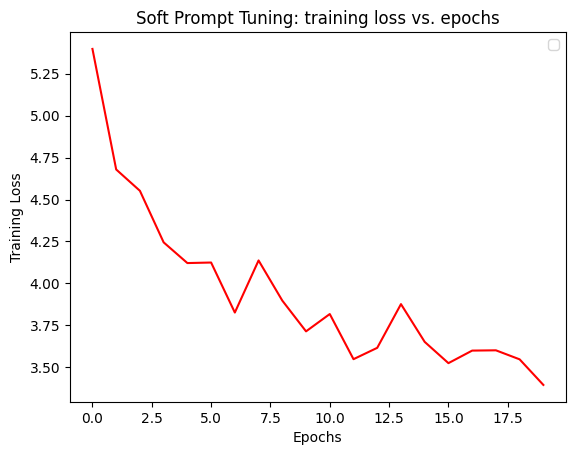

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


prompt_tuning_init=PromptTuningInit.TEXT, num_virtual_tokens=32 
[3.3599, 4.0508, 3.2009, 3.6572, 3.2996, 3.0142, 3.2646, 2.749, 2.7977, 3.174, 2.7172, 3.3476, 2.5872, 3.1185, 2.6656, 2.5696, 2.5076, 2.891, 2.8882, 2.107]


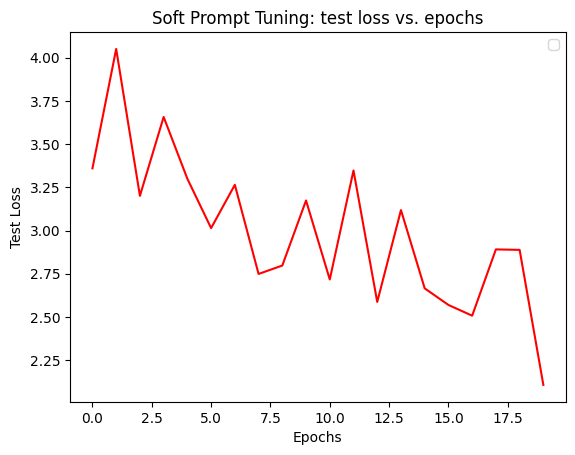

In [12]:
import matplotlib.pyplot as plt

train_losses = []

for log in trainer_sentences.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])

print(f"prompt_tuning_init={chosen_prompt_tuning_init}, num_virtual_tokens={chosen_num_virtual_tokens} \n" + str(train_losses))
# print(train_losses)

plt.title("Soft Prompt Tuning: training loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(range(len(train_losses)), train_losses, color ="red")
plt.legend()
plt.show()

test_losses = []

for log in test_sentences.state.log_history:
    if 'loss' in log:
        test_losses.append(log['loss'])

print(f"prompt_tuning_init={chosen_prompt_tuning_init}, num_virtual_tokens={chosen_num_virtual_tokens} \n" + str(test_losses))

plt.title("Soft Prompt Tuning: test loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.plot(range(len(test_losses)), test_losses, color ="red")
plt.legend()
plt.show()